# Title

## Load and Preview data

In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Train data shape: {x_train.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Train data shape: (60000, 28, 28)
Train labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


In [4]:
from image_dictionary import ImageDictionary
img_dict = ImageDictionary(x_train)
print(img_dict)

AttributeError: 'NoneType' object has no attribute 'flat'

In [33]:
print(type(x_train))
print(type(x_train.flat[0]))

<class 'numpy.ndarray'>
<class 'numpy.float32'>
(47040000,)


In [34]:
print(get_ipython().__class__.__name__)

ZMQInteractiveShell


In [38]:
import numpy as np
a = 200
b = np.sqrt(a).astype(int)
print(b)
c = a / b
print(c)

14
14.285714285714286


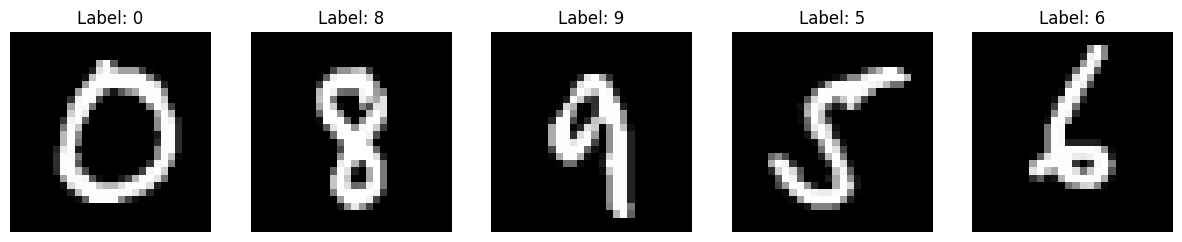

In [21]:
import random
import matplotlib.pyplot as plt

# Select 5 random indices
random_indices = random.sample(range(len(x_train)), 5)

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Display the image
    ax.imshow(x_train[random_indices[i]], cmap='gray')

    # Set the title with the label
    ax.set_title(f"Label: {y_train[random_indices[i]]}")

    # Remove the axis labels
    ax.axis('off')

# Show the plot
plt.show()


## Preprocessing

In [43]:
window_size = 5 # 5x5 window
step_size = 1   # 1 pixel step
height, width = x_train[0].shape
num_windows = (int((width-window_size)/step_size)+1, int((height-window_size)/step_size)+1)
window_images = np.zeros((len(x_train), np.prod(num_windows), window_size, window_size), dtype=np.float32)


for k, image in enumerate(x_train):
    for i in range(0, height - window_size + 1, step_size):
        for j in range(0, width - window_size + 1, step_size):
            window_images[k, i*num_windows[0]+j] = image[i:i+window_size, j:j+window_size]
            
# window_images = window_images.reshape(window_images.shape[0], window_images.shape[1], -1)
print(window_images.shape)

(60000, 576, 5, 5)


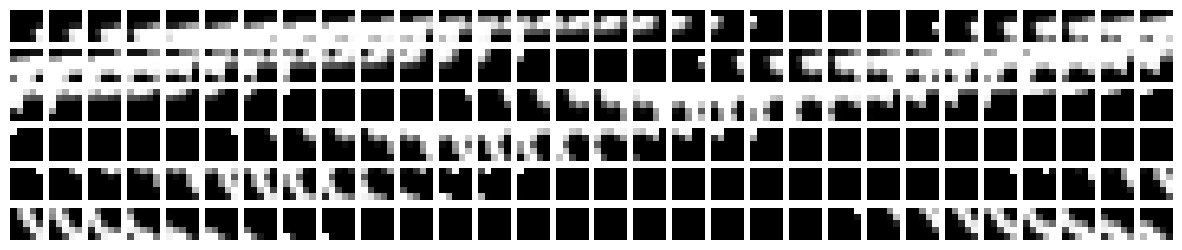

In [11]:
import matplotlib.pyplot as plt

offset = 100

fig, axes = plt.subplots(6, 30, figsize=(15, 3))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(window_images[0][i+offset], cmap='gray')
    ax.axis('off')

plt.show()


In [12]:
from sklearn.cluster import KMeans

X = window_images.reshape(window_images.shape[0], window_images.shape[1], -1)
X = X.reshape(-1, X.shape[-1])
print(X.shape)

Y_labels = np.zeros(window_images.shape[:2], dtype=np.uint8)
for i, num in enumerate(y_train):
    Y_labels[i,:] = num
Y_labels = Y_labels.reshape(-1)
print(Y_labels.shape)

# Zero mean and unit variance
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

(34560000, 25)
(34560000,)


Should we remove zero patches? Not sure...

In [ ]:
# # remove patches with all zeros
# mask = np.sum(X, axis=1) != 0
# X = X[mask]
# Y_labels = Y_labels[mask]

Takes 12 minutes

In [15]:
K = 100 # Number of clusters, range from 100 to 10000
km = KMeans(n_clusters=K, n_init='auto', verbose=1)
Phi = km.fit(X)

Initialization complete
Iteration 0, inertia 172828960.0.
Iteration 1, inertia 137973184.0.
Iteration 2, inertia 135122560.0.
Iteration 3, inertia 133883368.0.
Iteration 4, inertia 133145160.0.
Iteration 5, inertia 132564080.0.
Iteration 6, inertia 132074080.0.
Iteration 7, inertia 131685024.0.
Iteration 8, inertia 131384112.0.
Iteration 9, inertia 131142792.0.
Iteration 10, inertia 130940328.0.
Iteration 11, inertia 130766720.0.
Iteration 12, inertia 130616784.0.
Iteration 13, inertia 130484696.0.
Iteration 14, inertia 130370944.0.
Iteration 15, inertia 130270880.0.
Iteration 16, inertia 130186400.0.
Iteration 17, inertia 130112576.0.
Iteration 18, inertia 130049792.0.
Iteration 19, inertia 129995968.0.
Iteration 20, inertia 129948256.0.
Iteration 21, inertia 129907680.0.
Iteration 22, inertia 129872728.0.
Iteration 23, inertia 129840616.0.
Iteration 24, inertia 129812456.0.
Iteration 25, inertia 129786968.0.
Iteration 26, inertia 129763008.0.
Iteration 27, inertia 129739504.0.
Iterat

In [19]:
np.save('Phi.npy', Phi.cluster_centers_)

In [23]:
Phi = np.load('Phi.npy')

In [44]:
print(Phi.shape)

(100, 25)


(100, 25)


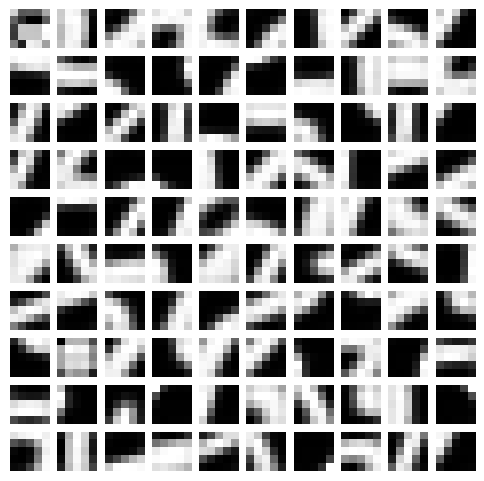

In [45]:
import matplotlib.pyplot as plt

dict_images = km.cluster_centers_.reshape(K, window_size, window_size)
fig, axes = plt.subplots(10, 10, figsize=(6, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(dict_images[i], cmap='gray')
    ax.axis('off')

plt.show()


* Should I use the pixels as dimensions? (5*5 = 25) -> yes
* or... maybe extract features? Eigenvectors? for dimensions -> no, but can reduce dimensions
* Can I use a library for finding the centroids? -> yes
* Would I have a codebook (group of centroids) for every image? Maybe group up the codebooks by label -> cluster everything (all pictures with all patches)

In [53]:
from sklearn.metrics import euclidean_distances 
test = window_images.reshape(window_images.shape[0], window_images.shape[1], -1)
test = test.reshape(-1, test.shape[-1])
print(test.shape)
test -= np.mean(test, axis=0)
test /= np.std(test, axis=0)
print(np.where(test == np.NaN))
print(np.where(Phi == np.NaN))
dist = euclidean_distances(test, Phi)
print(dist.shape)

(34560000, 25)
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


ValueError: Input contains NaN.